Fonte: https://terrabrasilis.dpi.inpe.br/queimadas/portal/pages/secao_downloads/dados-abertos/#da-focos

In [25]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

import sys
from pathlib import Path

notebook_dir = Path().resolve()
project_root = notebook_dir.parent
sys.path.insert(0, str(project_root))

import locale
try:
    locale.setlocale(locale.LC_ALL, 'Portuguese_Brazil')
except:
    pass

## Carregamento e exploração inicial dos dados

In [26]:
df = pl.read_parquet('../data/raw/queimadas_2015-2024.parquet')

print(f'\nDimensões: {df.height:,} linhas x {df.width} colunas')
print(f'Uso de memória: {df.estimated_size('mb'):.2f} MB')


Dimensões: 40,442,317 linhas x 13 colunas
Uso de memória: 4218.41 MB


In [27]:
df.head()

latitude,longitude,data_pas,satelite,pais,estado,municipio,bioma,numero_dias_sem_chuva,precipitacao,risco_fogo,id_area_industrial,frp
str,str,str,str,str,str,str,str,str,f64,f64,str,str
""" -11.561960""",""" -55.093250""","""2015-06-08 05:41:00""","""NPP-375D""","""Brasil""","""MATO GROSSO""","""CLÁUDIA""","""Amazônia""","""16""",0.0,0.5,"""0""",null
""" -9.522970""",""" -55.172350""","""2015-06-08 05:40:00""","""NPP-375D""","""Brasil""","""MATO GROSSO""","""NOVO MUNDO""","""Amazônia""","""9""",0.0,0.7,"""0""",null
""" -20.762530""",""" -46.769690""","""2015-06-08 04:03:00""","""NPP-375D""","""Brasil""","""MINAS GERAIS""","""ITAÚ DE MINAS""","""Mata Atlântica""","""5""",0.0,-999.0,"""0""",null
""" -5.355910""",""" -45.107430""","""2015-06-08 03:58:00""","""NPP-375D""","""Brasil""","""MARANHÃO""","""BARRA DO CORDA""","""Cerrado""","""2""",1.1,1.0,"""0""",null
""" -15.837070""",""" -45.672990""","""2015-06-08 04:01:00""","""NPP-375D""","""Brasil""","""MINAS GERAIS""","""URUCUIA""","""Cerrado""","""25""",0.0,1.0,"""0""",null


In [28]:
df.schema

Schema([('latitude', String),
        ('longitude', String),
        ('data_pas', String),
        ('satelite', String),
        ('pais', String),
        ('estado', String),
        ('municipio', String),
        ('bioma', String),
        ('numero_dias_sem_chuva', String),
        ('precipitacao', Float64),
        ('risco_fogo', Float64),
        ('id_area_industrial', String),
        ('frp', String)])

In [29]:
df.describe()

statistic,latitude,longitude,data_pas,satelite,pais,estado,municipio,bioma,numero_dias_sem_chuva,precipitacao,risco_fogo,id_area_industrial,frp
str,str,str,str,str,str,str,str,str,str,f64,f64,str,str
"""count""","""40442317""","""40442317""","""40442317""","""40442317""","""40442317""","""40442317""","""40442317""","""40442190""","""40190765""",4.0190765e7,4.0190765e7,"""40442317""","""25468846"""
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""127""","""251552""",251552.0,251552.0,"""0""","""14973471"""
"""mean""",null,null,null,null,null,null,null,null,null,0.730647,-10.289476,null,null
"""std""",null,null,null,null,null,null,null,null,null,3.477508,104.61418,null,null
"""min""",""" .000000 """,""" -34.795780 ""","""2015-01-01 01:43:00""","""AQUA_M""","""Brasil""","""ACRE""","""ABADIA DE GOIÁS""","""Amazônia""",""" -999 """,0.0,-999.0,""" 0 ""","""-0.1"""
"""25%""",null,null,null,null,null,null,null,null,null,0.0,0.6,null,null
"""50%""",null,null,null,null,null,null,null,null,null,0.0,1.0,null,null
"""75%""",null,null,null,null,null,null,null,null,null,0.0,1.0,null,null
"""max""",""" -33.733560""",""" -73.910000""","""2024-12-31 23:50:00""","""TERRA_M-T""","""Brasil""","""TOCANTINS""","""ÓLEO""","""Pantanal""","""99.0""",252.98,1.0,"""0""","""999.9"""


Como há uma quantidade massiva de dados, vamos filtrar apenas pelos satélites com maior quantidade de registros.

In [30]:
df['satelite'].value_counts().sort(by='count', descending=True)

satelite,count
str,u32
"""NPP-375""",9729649
"""GOES-16""",8713202
"""NOAA-20""",8676477
"""NPP-375D""",4523439
"""AQUA_M-T""",2017251
…,…
"""NOAA-19D""",108738
"""NOAA-15""",80991
"""NOAA-15D""",4836


In [31]:
df = df.filter(
    pl.col('satelite').is_in(['NOAA-20', 'NPP-375', 'GOES-16'])
)

In [32]:
df.null_count()

latitude,longitude,data_pas,satelite,pais,estado,municipio,bioma,numero_dias_sem_chuva,precipitacao,risco_fogo,id_area_industrial,frp
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,72,210745,210745,210745,0,10463043


Vamos remover colunas que não serão úteis para a análise: país, pois todos os dados são do Brasil; município, porque já temos estado, latitude e longitude; e id_area_industrial, que não será utilizado nesta análise.

In [33]:
df = df.drop(['pais', 'municipio', 'id_area_industrial'])
df.schema

Schema([('latitude', String),
        ('longitude', String),
        ('data_pas', String),
        ('satelite', String),
        ('estado', String),
        ('bioma', String),
        ('numero_dias_sem_chuva', String),
        ('precipitacao', Float64),
        ('risco_fogo', Float64),
        ('frp', String)])

Agora vamos converter os tipos de dados para tipos mais apropriados, uma vez que o dataset está bem inconsistente nesse sentido.

In [34]:
df = df.with_columns([
    pl.col('latitude').str.strip_chars().cast(pl.Float64),
    pl.col('longitude').str.strip_chars().cast(pl.Float64),
    pl.col('data_pas').str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S"),
    pl.col('satelite').cast(pl.Categorical),
    pl.col('estado').cast(pl.Categorical),
    pl.col('bioma').cast(pl.Categorical),
    pl.col('numero_dias_sem_chuva').str.strip_chars().cast(pl.Float64).cast(pl.Int64),
    pl.col('frp').str.strip_chars().cast(pl.Float64),
])
df.head()

latitude,longitude,data_pas,satelite,estado,bioma,numero_dias_sem_chuva,precipitacao,risco_fogo,frp
f64,f64,datetime[μs],cat,cat,cat,i64,f64,f64,f64
4.10405,-61.15007,2015-01-06 17:51:00,"""NPP-375""","""RORAIMA""","""Amazônia""",20,0.1,0.7,null
-4.28432,-44.83284,2015-01-08 17:11:00,"""NPP-375""","""MARANHÃO""","""Amazônia""",3,0.2,1.0,null
-3.22881,-42.34033,2015-01-08 17:11:00,"""NPP-375""","""MARANHÃO""","""Cerrado""",6,0.0,0.9,null
2.92878,-60.08455,2015-01-06 17:51:00,"""NPP-375""","""RORAIMA""","""Amazônia""",11,0.0,1.0,null
-6.85993,-47.04064,2015-01-09 16:51:00,"""NPP-375""","""MARANHÃO""","""Cerrado""",3,0.0,0.6,null


In [135]:
df.describe()

statistic,latitude,longitude,data_pas,satelite,estado,bioma,numero_dias_sem_chuva,precipitacao,risco_fogo,frp,ano,hora,dia_semana,dia_ano,semana_ano,mes,trimestre,periodo_dia,estacao_ano,periodo_climatico,data_dia
str,f64,f64,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str
"""count""",1.6652191e7,1.6652191e7,"""16652191""","""16652191""","""16652191""","""16652171""",1.6323972e7,1.6506452e7,1.632853e7,1.6652191e7,1.6652191e7,1.6652191e7,1.6652191e7,1.6652191e7,1.6652191e7,1.6652191e7,1.6652191e7,"""16652191""","""16652191""","""16652191""","""16652191"""
"""null_count""",0.0,0.0,"""0""","""0""","""0""","""20""",328219.0,145739.0,323661.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""","""0""","""0"""
"""mean""",-9.947048,-52.200713,"""2022-11-01 12:44:49.633089""",null,null,null,25.322983,0.755642,0.742594,36.747841,2022.154812,14.613458,3.991157,248.572573,35.932209,8.672327,3.186575,null,null,null,"""2022-10-31 21:38:54.090474"""
"""std""",5.87251,7.582151,null,null,null,null,35.405326,3.610981,0.34963,63.727645,1.708522,5.266822,1.954944,60.903342,8.702934,2.017377,0.709755,null,null,null,null
"""min""",-33.74551,-73.86338,"""2018-04-01 15:12:00""",null,null,null,0.0,0.0,0.0,0.1,2018.0,0.0,1.0,1.0,1.0,1.0,1.0,null,null,null,"""2018-04-01"""
"""25%""",-13.1313,-57.33944,"""2021-09-11 17:37:00""",null,null,null,3.0,0.0,0.5,4.7,2021.0,15.0,2.0,229.0,33.0,8.0,3.0,null,null,null,"""2021-09-11"""
"""50%""",-9.15919,-51.5465,"""2023-03-07 05:46:00""",null,null,null,9.0,0.0,1.0,10.2,2023.0,16.0,4.0,254.0,37.0,9.0,3.0,null,null,null,"""2023-03-07"""
"""75%""",-6.2338,-46.03417,"""2024-06-14 04:57:00""",null,null,null,32.0,0.0,1.0,53.3,2024.0,17.0,6.0,284.0,41.0,10.0,4.0,null,null,null,"""2024-06-14"""
"""max""",5.21761,-34.79578,"""2024-12-31 23:50:00""",null,null,null,836.0,157.2,1.0,8014.3,2024.0,23.0,7.0,366.0,53.0,12.0,4.0,null,null,null,"""2024-12-31"""


## Tratamento de valores inválidos e duplicatas
- Podemos observar que o número de dias sem chuva e o risco de fogo possuem valores -999, que indicam dados inválidos ou ausentes. Vamos substituir esses valores por nulos.
- Além disso, o FRP (Fire Radiative Power) possui tanto valores nulos quanto menores ou iguais a 0, então vamos remover esses registros.

In [36]:
df = df.with_columns([
    pl.when(pl.col('numero_dias_sem_chuva') == -999)
      .then(None)
      .otherwise(pl.col('numero_dias_sem_chuva'))
      .alias('numero_dias_sem_chuva'),

    pl.when(pl.col('risco_fogo') == -999)
      .then(None)
      .otherwise(pl.col('risco_fogo'))
      .alias('risco_fogo'),
])

df = df.drop_nulls(subset=['frp'])

df = df.filter(pl.col('frp') > 0)
print(f'Dimensões após remoção de valores inválidos: {df.height:,} linhas x {df.width} colunas')

Dimensões após remoção de valores inválidos: 16,652,766 linhas x 10 colunas


In [37]:
duplicates_count = df.is_duplicated().sum()
print(f'Número de registros duplicados: {duplicates_count}')

# Mantém o registro com maior potência radiativa de fogo
df = df.sort(by='frp', descending=True).unique(keep='first')
print(f'Dimensões após remoção de duplicatas: {df.height:,} linhas x {df.width} colunas')

Número de registros duplicados: 770
Dimensões após remoção de duplicatas: 16,652,381 linhas x 10 colunas


### Feature Engineering e agrupamento de registros por dia

**Insight**: Podemos observar que o número de registros para 2015 e 2016 caiu para 0 após o tratamento dos dados. 2017, por sua vez, ficou com apenas 190 exemplos, o que nos permite removê-los sem comprometer a análise.

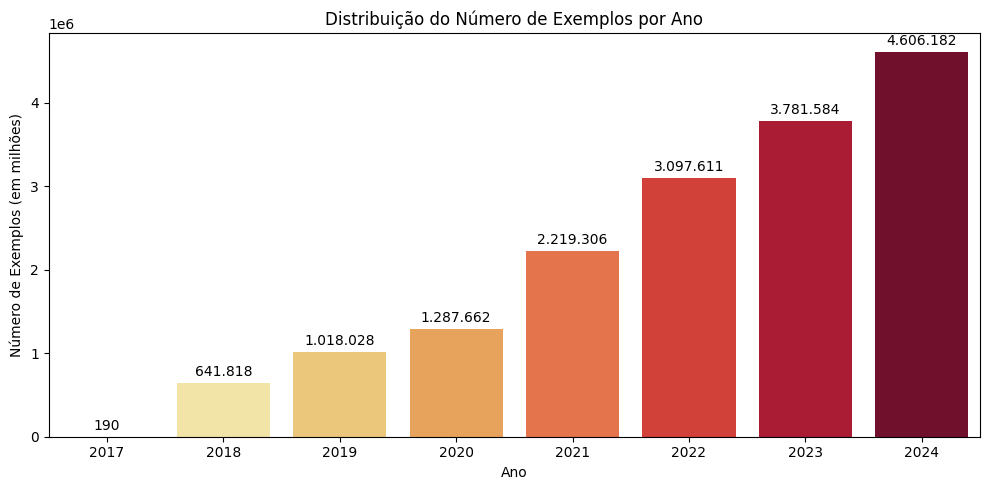

In [39]:
df = df.with_columns([
    pl.col('data_pas').dt.year().alias('ano')
])

records_per_year = (
    df
    .group_by('ano')
    .agg(pl.len().alias('registros'))
    .sort('ano')
)

fig = plt.figure(figsize=(10, 5))
ax = sns.barplot(
    records_per_year, x='ano', y='registros', hue='ano',
    legend=False, palette='YlOrRd'
)

for container in ax.containers:
    labels = [f'{x:,.0f}'.replace(',', '.') for x in container.datavalues]
    ax.bar_label(container, labels=labels, label_type='edge', padding=3)

plt.title('Distribuição do Número de Exemplos por Ano')
plt.ylabel('Número de Exemplos (em milhões)')
plt.xlabel('Ano')
plt.tight_layout()
plt.show()

In [40]:
df = df.filter(pl.col('ano') >= 2018)

In [41]:
df = df.with_columns([
    pl.col('data_pas').dt.hour().cast(pl.Int8).alias('hora'),
    pl.col('data_pas').dt.weekday().cast(pl.Int8).alias('dia_semana'),
    pl.col('data_pas').dt.ordinal_day().cast(pl.Int16).alias('dia_ano'),
    ((pl.col('data_pas').dt.ordinal_day() - 1) // 7 + 1).cast(pl.Int8).alias('semana_ano'),
    pl.col('data_pas').dt.month().cast(pl.Int8).alias('mes'),
    pl.col('data_pas').dt.quarter().cast(pl.Int8).alias('trimestre'),
])

# Definição do período do dia
df = df.with_columns([
    pl.when(pl.col('hora') < 6).then(pl.lit('Madrugada'))
      .when(pl.col('hora') < 12).then(pl.lit('Manhã'))
      .when(pl.col('hora') < 18).then(pl.lit('Tarde'))
      .otherwise(pl.lit('Noite'))
      .cast(pl.Categorical)
      .alias('periodo_dia')
])

# Definição da estação do ano (Brasil)
df = df.with_columns([
    pl.when(pl.col('mes').is_in([12, 1, 2])).then(pl.lit('Verão'))
      .when(pl.col('mes').is_in([3, 4, 5])).then(pl.lit('Outono'))
      .when(pl.col('mes').is_in([6, 7, 8])).then(pl.lit('Inverno'))
      .otherwise(pl.lit('Primavera'))
      .cast(pl.Categorical)
      .alias('estacao_ano')
])

# Definição do período climático com base no bioma e mês
df = df.with_columns([
    pl.when((pl.col('bioma') == 'Amazônia') & pl.col('mes').is_in([6, 7, 8, 9, 10, 11]))
      .then(pl.lit('Seco'))
      .when((pl.col('bioma') == 'Cerrado') & pl.col('mes').is_in([5, 6, 7, 8, 9]))
      .then(pl.lit('Seco'))
      .when((pl.col('bioma') == 'Caatinga') & pl.col('mes').is_in([6, 7, 8, 9, 10, 11, 12]))
      .then(pl.lit('Seco'))
      .otherwise(pl.lit('Chuvoso'))
      .cast(pl.Categorical)
      .alias('periodo_climatico')
])

Também sabemos da fonte que pode haver múltiplos registros de focos de queimadas em um mesmo dia e local, mas em horários diferentes. Contudo, esse nível de granularidade não é necessário para a análise que pretendemos fazer. Desse modo, vamos agrupar esses registros, a princípio, a nível de dia.

In [42]:
df = df.with_columns([
    pl.col('data_pas').dt.date().alias('data_dia')
])

GROUP_COLS = ['latitude', 'longitude', 'data_dia', 'bioma', 'estado']

# Agrega com base em critérios específicos e renomeia cada feature
df_daily = df.group_by(GROUP_COLS).agg([
    pl.col('satelite').n_unique().alias('num_deteccoes_dia'),

    pl.col('numero_dias_sem_chuva').max().alias('num_dias_sem_chuva_max'),
    pl.col('precipitacao').max().alias('precipitacao_max'),
    pl.col('risco_fogo').max().alias('risco_fogo_max'),

    pl.col('frp').max().alias('frp'),

    pl.col('ano').first().alias('ano'),
    pl.col('mes').first().alias('mes'),
    pl.col('dia_ano').first().alias('dia_ano'),
    pl.col('dia_semana').first().alias('dia_semana'),
    pl.col('semana_ano').first().alias('semana_ano'),
    pl.col('trimestre').first().alias('trimestre'),

    pl.col('periodo_dia').mode().first().alias('periodo_dia_predominante'),
    pl.col('estacao_ano').first().alias('estacao_ano'),
    pl.col('periodo_climatico').first().alias('periodo_climatico'),

    pl.col('hora').min().alias('hora_primeira_deteccao'),
    pl.col('hora').max().alias('hora_ultima_deteccao'),
])

# Converte as variáveis categóricas
CAT_VARS = [
    'mes', 'dia_ano', 'dia_semana', 'semana_ano', 'trimestre',
    'periodo_dia_predominante', 'estacao_ano', 'periodo_climatico',
    'bioma', 'estado'
]
with pl.StringCache():
    df_daily = df_daily.with_columns([
        pl.col(c).cast(pl.Utf8).cast(pl.Categorical)
        for c in CAT_VARS if c in df_daily.columns
    ])

In [43]:
print(f'\nDimensões do dataset diário: {df_daily.height:,} linhas x {df_daily.width} colunas')


Dimensões do dataset diário: 13,586,113 linhas x 21 colunas


In [44]:
df_daily['ano'].value_counts()

ano,count
i32,u32
2019,1018027
2024,3337851
2023,2609450
2018,641817
2021,2218172
2020,1287661
2022,2473135


In [45]:
df_daily.null_count()

latitude,longitude,data_dia,bioma,estado,num_deteccoes_dia,num_dias_sem_chuva_max,precipitacao_max,risco_fogo_max,frp,ano,mes,dia_ano,dia_semana,semana_ano,trimestre,periodo_dia_predominante,estacao_ano,periodo_climatico,hora_primeira_deteccao,hora_ultima_deteccao
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,20,0,0,281187,111762,266657,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
df_daily.is_duplicated().sum()

0

## Análise univariada

In [47]:
out = {}

CATEGORICAL_COLS = [
    'bioma', 'estado', 'mes', 'dia_ano', 'dia_semana',
    'semana_ano', 'trimestre', 'periodo_dia_predominante',
    'estacao_ano', 'periodo_climatico'
]

NUMERIC_COLS = [
    'latitude', 'longitude',
    'num_deteccoes_dia', 'num_dias_sem_chuva_max',
    'precipitacao_max', 'risco_fogo_max', 'frp',
    'hora_primeira_deteccao', 'hora_ultima_deteccao',
]

DATE_COLS = ['data_dia']

ORDINAL_TIME_COLS = ['ano']

### Features numéricas
**Insight**: No geral, as variáveis numéricas possuem distribuições diferentes entre si. As mais concentradas são `frp`, `precipitacao_max` e `num_deteccoes_dia` e, as com mais outliers, `frp`, `precipitacao_max` e `num_dias_sem_chuva_max`.

In [48]:
numerical_stats = df_daily.select(NUMERIC_COLS).describe()
out['numerical_stats'] = numerical_stats
numerical_stats

statistic,latitude,longitude,num_deteccoes_dia,num_dias_sem_chuva_max,precipitacao_max,risco_fogo_max,frp,hora_primeira_deteccao,hora_ultima_deteccao
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1.3586113e7,1.3586113e7,1.3586113e7,1.3304926e7,1.3474351e7,1.3319456e7,1.3586113e7,1.3586113e7,1.3586113e7
"""null_count""",0.0,0.0,0.0,281187.0,111762.0,266657.0,0.0,0.0,0.0
"""mean""",-10.049083,-51.853394,1.000001,25.316655,0.793361,0.739655,21.05673,14.565002,14.66961
"""std""",6.019474,7.699611,0.00094,35.897431,3.671229,0.353355,46.084822,4.6985,4.676021
"""min""",-33.74551,-73.86338,1.0,0.0,0.0,0.0,0.1,0.0,0.0
"""25%""",-13.31175,-57.0997,1.0,3.0,0.0,0.5,4.0,16.0,16.0
"""50%""",-9.17613,-51.05336,1.0,9.0,0.0,1.0,7.6,16.0,16.0
"""75%""",-6.22808,-45.669,1.0,32.0,0.0,1.0,16.8,17.0,17.0
"""max""",5.21761,-34.79578,2.0,836.0,157.2,1.0,8014.3,23.0,23.0


In [49]:
def col_stats(c: str) -> pl.DataFrame:
    x = pl.col(c).drop_nulls().cast(pl.Float64)
    return df_daily.select(
        pl.lit(c).alias('variavel'),
        x.quantile(0.25).alias('q1'),
        x.median().alias('median'),
        x.quantile(0.75).alias('q3'),
    )

In [50]:
# Por razões de performance, amostrar somente uma quantidade
# limitada de outliers e pontos por variável
MAX_OUTLIERS_PER_VAR = 3000

stats = (
    pl.concat([col_stats(c) for c in NUMERIC_COLS], how='vertical')
    .with_columns([
        (pl.col('q3') - pl.col('q1')).alias('iqr'),
        (pl.col('q1') - 1.5 * (pl.col('q3') - pl.col('q1'))).alias('lowerfence'),
        (pl.col('q3') + 1.5 * (pl.col('q3') - pl.col('q1'))).alias('upperfence'),
    ])
    .select(['variavel', 'q1', 'median', 'q3', 'lowerfence', 'upperfence'])
)

s = stats.to_dict(as_series=False)

outliers_long = (
    df_daily
    .select(NUMERIC_COLS)
    .unpivot(variable_name='variavel', value_name='valor')
    .drop_nulls('valor')
    .with_columns(pl.col('valor').cast(pl.Float64))
    .join(stats.select(['variavel', 'lowerfence', 'upperfence']), on='variavel', how='inner')
    .filter((pl.col('valor') < pl.col('lowerfence')) | (pl.col('valor') > pl.col('upperfence')))
    # Pega os outliers mais distantes das cercas
    .with_columns(
        pl.when(pl.col('valor') < pl.col('lowerfence'))
          .then(pl.col('lowerfence') - pl.col('valor'))
          .otherwise(pl.col('valor') - pl.col('upperfence'))
          .alias('dist_fence')
    )
    .sort(['variavel', 'dist_fence'], descending=[False, True])
    .group_by('variavel', maintain_order=True)
    .head(MAX_OUTLIERS_PER_VAR)
    .select(['variavel', 'valor'])
)

o = outliers_long.to_dict(as_series=False)

n_rows = 3
n_cols = 3

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    subplot_titles=NUMERIC_COLS,
    vertical_spacing=0.15,
    horizontal_spacing=0.06
)

for idx, var in enumerate(NUMERIC_COLS):
    row = (idx // n_cols) + 1
    col = (idx % n_cols) + 1

    var_idx = s['variavel'].index(var)

    fig.add_trace(
        go.Box(
            q1=[s['q1'][var_idx]],
            median=[s['median'][var_idx]],
            q3=[s['q3'][var_idx]],
            lowerfence=[s['lowerfence'][var_idx]],
            upperfence=[s['upperfence'][var_idx]],
            boxpoints=False,
            name=var,
            showlegend=False,
            marker_color='steelblue',
            line=dict(width=1.5),
            x=[var]
        ),
        row=row, col=col
    )

    outlier_vals = [o['valor'][i] for i, v in enumerate(o['variavel']) if v == var]

    if outlier_vals:
        fig.add_trace(
            go.Scatter(
                x=[var] * len(outlier_vals),
                y=outlier_vals,
                mode='markers',
                name='Outliers (amostrados)',
                showlegend=(idx == 0),
                marker=dict(size=3, opacity=0.6, color='red')
            ),
            row=row, col=col
        )

    fig.update_xaxes(showticklabels=False, row=row, col=col)

    fig.update_yaxes(title_text='', row=row, col=col)

# Layout geral
fig.update_layout(
    title_text='Distribuição das Variáveis Numéricas',
    title_font_size=18,
    height=1050,
    width=1050,
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.08,
        xanchor="center",
        x=0.5
    )
)

fig.show()

### Features categóricas
**Insights**:
- A Amazônia é o bioma com maior número de focos de queimadas, representando 46,5% dos registros.
- Os estados do Pará (18,4%) e Mato Grosso (15,7%) são os que mais apresentam focos de queimadas.
- Os meses de agosto (21,3%) e setembro (29,5%) concentram a maioria dos registros.
- O 3º trimestre do ano (57%) é o período com mais focos de queimadas.
- A maioria dos focos de queimadas ocorre à tarde (73,4%).
- A primavera (57,7%) é a estação do ano com mais registros de queimadas.
- O período seco (73,3%) é o que apresenta a maior quantidade de focos de queimadas.

In [51]:
cat_summaries = {}
for col in CATEGORICAL_COLS:
    var_count = (
        df_daily
        .group_by(col)
        .len()
        .sort('len', descending=True)
        .rename({'len': 'count'})
    )
    var_count = var_count.with_columns((pl.col('count') / df_daily.height).alias('pct'))
    cat_summaries[col] = var_count

out['categorical_summaries'] = cat_summaries
cat_summaries

{'bioma': shape: (7, 3)
 ┌────────────────┬─────────┬──────────┐
 │ bioma          ┆ count   ┆ pct      │
 │ ---            ┆ ---     ┆ ---      │
 │ cat            ┆ u32     ┆ f64      │
 ╞════════════════╪═════════╪══════════╡
 │ Amazônia       ┆ 6329555 ┆ 0.465884 │
 │ Cerrado        ┆ 4396363 ┆ 0.323592 │
 │ Caatinga       ┆ 1182761 ┆ 0.087057 │
 │ Mata Atlântica ┆ 933904  ┆ 0.06874  │
 │ Pantanal       ┆ 690710  ┆ 0.050839 │
 │ Pampa          ┆ 52800   ┆ 0.003886 │
 │ null           ┆ 20      ┆ 0.000001 │
 └────────────────┴─────────┴──────────┘,
 'estado': shape: (27, 3)
 ┌─────────────────────┬─────────┬──────────┐
 │ estado              ┆ count   ┆ pct      │
 │ ---                 ┆ ---     ┆ ---      │
 │ cat                 ┆ u32     ┆ f64      │
 ╞═════════════════════╪═════════╪══════════╡
 │ PARÁ                ┆ 2497610 ┆ 0.183836 │
 │ MATO GROSSO         ┆ 2134562 ┆ 0.157114 │
 │ MARANHÃO            ┆ 1309348 ┆ 0.096374 │
 │ AMAZONAS            ┆ 1037793 ┆ 0.076386 │
 │

A seguir, fazemos uma análise das variáveis categóricas de tempo.

In [52]:
out['freq_by_year'] = df_daily.group_by('ano').len().sort('ano').rename({'len': 'count'})
out['freq_by_month'] = df_daily.group_by('mes').len().sort('mes').rename({'len': 'count'})
out['freq_by_weekday'] = df_daily.group_by('dia_semana').len().sort('dia_semana').rename({'len': 'count'})
out

{'numerical_stats': shape: (9, 10)
 ┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
 │ statistic ┆ latitude  ┆ longitude ┆ num_detec ┆ … ┆ risco_fog ┆ frp       ┆ hora_prim ┆ hora_ult │
 │ ---       ┆ ---       ┆ ---       ┆ coes_dia  ┆   ┆ o_max     ┆ ---       ┆ eira_dete ┆ ima_dete │
 │ str       ┆ f64       ┆ f64       ┆ ---       ┆   ┆ ---       ┆ f64       ┆ ccao      ┆ ccao     │
 │           ┆           ┆           ┆ f64       ┆   ┆ f64       ┆           ┆ ---       ┆ ---      │
 │           ┆           ┆           ┆           ┆   ┆           ┆           ┆ f64       ┆ f64      │
 ╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
 │ count     ┆ 1.3586113 ┆ 1.3586113 ┆ 1.3586113 ┆ … ┆ 1.3319456 ┆ 1.3586113 ┆ 1.3586113 ┆ 1.358611 │
 │           ┆ e7        ┆ e7        ┆ e7        ┆   ┆ e7        ┆ e7        ┆ e7        ┆ 3e7      │
 │ null_coun ┆ 0.0       ┆ 0.0       ┆ 0.0     

## Análise de correlação
**Insights**
Correlações das variáveis numéricas mais relevantes:
- `hora_primeira_deteccao` e `hora_ultima_deteccao`:  0,97
- `num_dias_sem_chuva_max` e `risco_fogo_max`:  0,42
- `longitude` e `risco_fogo_max`:  0,33
- `precipitacao_max` e `risco_fogo_max`: -0,36

A análise de correlação das variáveis categóricas mostrou muitos relacionamentos "óbvios", como mês com trimestre ou dia do ano com semana do ano.

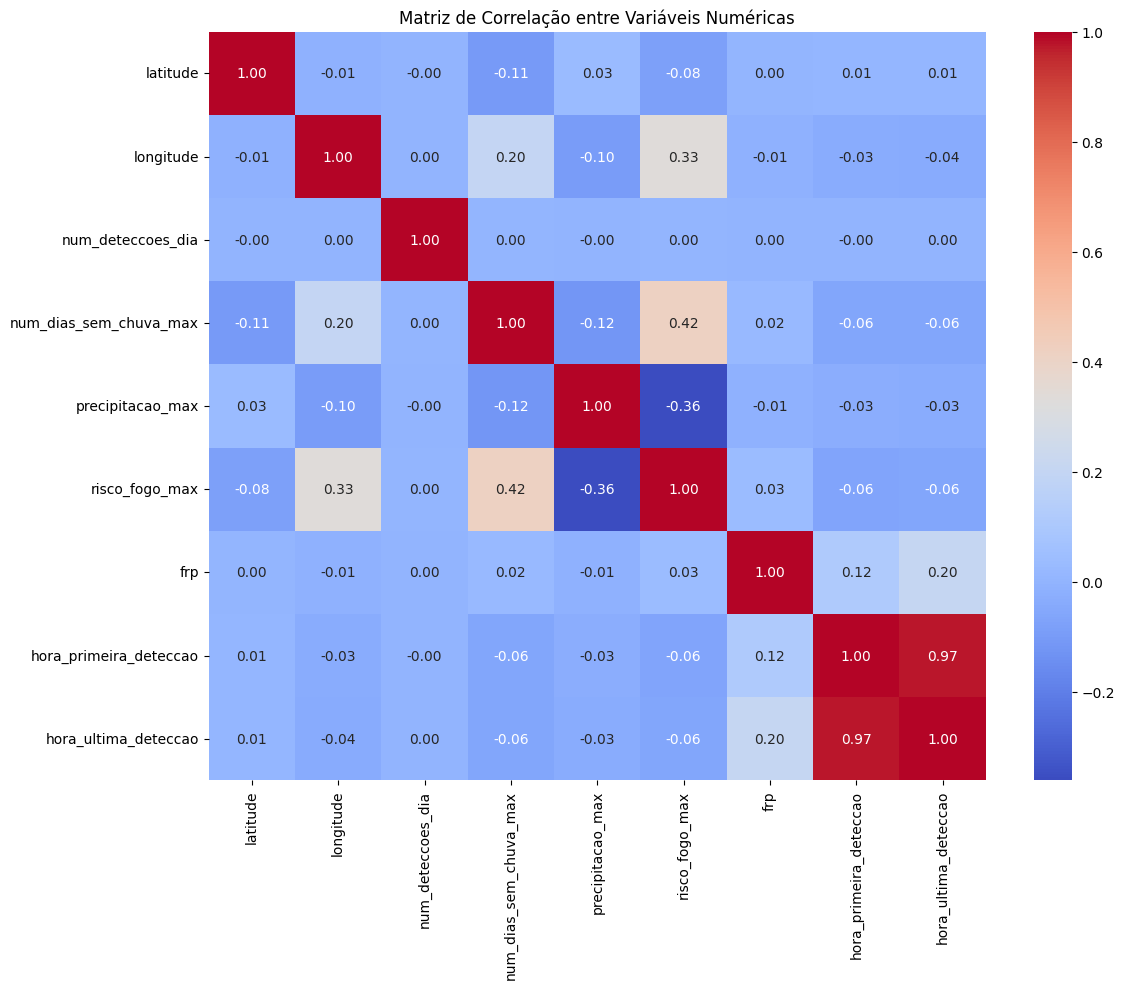

In [53]:
corr_pd = df_daily.select(NUMERIC_COLS).to_pandas().corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_pd, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matriz de Correlação entre Variáveis Numéricas')
plt.tight_layout()
plt.show()

Para a análise de correlação entre variáveis categóricas, utilizamos o V de Cramer, computado como:
$$
V = \sqrt{\frac{\mathrm{χ}^2}{n \times \min(k - 1, r - 1)}},
$$
Onde:
- $\mathrm{χ}^2$ é o valor do teste qui-quadrado;
- $n$ é o número de elementos incluídos na tabela;
- $k$ é o número de colunas;
- $r$ é o número de linhas.

Quanto mais próximo V é de 0, menor é a associação entre as variáveis analisadas.

In [54]:
from scripts.cramers import Cramers
import itertools

cat_corr = []
for x1, x2 in itertools.combinations(CATEGORICAL_COLS, 2):
    v = Cramers(df_daily, x1, x2).compute_v()
    cat_corr.append({
        'var1': x1,
        'var2': x2,
        'cramers_v': v,
    })

cat_corr_df = pl.DataFrame(cat_corr).sort('cramers_v', descending=True)
cat_corr_df

var1,var2,cramers_v
str,str,f64
"""mes""","""trimestre""",1.0
"""mes""","""estacao_ano""",1.0
"""dia_ano""","""semana_ano""",1.0
"""dia_ano""","""trimestre""",0.997706
"""dia_ano""","""estacao_ano""",0.995317
…,…,…
"""dia_semana""","""periodo_climatico""",0.02566
"""mes""","""dia_semana""",0.024703
"""dia_semana""","""estacao_ano""",0.020388


## Análise de sazonalidade

In [55]:
out_season = {}

df_m = (
    df_daily
    .with_columns([
        pl.col("data_dia").dt.truncate("1mo").alias("mes_inicio"),
        pl.col("data_dia").dt.year().alias("ano_mes_year"),
        pl.col("data_dia").dt.month().alias("ano_mes_month"),
        pl.col("data_dia").dt.day().alias("dia_mes"),
    ])
    .with_columns([
        (pl.col("ano_mes_year").cast(pl.Utf8) + "-" +
         pl.col("ano_mes_month").cast(pl.Utf8).str.zfill(2)).alias("ano_mes"),

        pl.col("mes_inicio").dt.month_end().dt.day().alias("dias_no_mes"),

        (pl.col("latitude").round(4).cast(pl.Utf8) + "_" + pl.col("longitude").round(4).cast(pl.Utf8)).alias("pt")
    ])
)

# Média por mês ao longo dos anos
monthly = (
    df_m.group_by(["mes_inicio", "ano_mes_year", "ano_mes_month", "ano_mes", "dias_no_mes"])
        .agg([
            pl.len().alias("n_dias_com_evento"),
            pl.col("num_deteccoes_dia").sum().alias("total_deteccoes_mes"),
            pl.col("num_deteccoes_dia").mean().alias("media_deteccoes_por_dia_evento"),
            pl.col("num_deteccoes_dia").median().alias("mediana_deteccoes_por_dia_evento"),
            pl.col("num_deteccoes_dia").quantile(0.9).alias("p90_deteccoes_por_dia_evento"),
            pl.col("num_deteccoes_dia").quantile(0.95).alias("p95_deteccoes_por_dia_evento"),

            (pl.col("num_deteccoes_dia").sum() / pl.col("dias_no_mes").first()).alias("deteccoes_por_dia_calendario"),

            pl.n_unique("pt").alias("n_pontos_distintos"),

            pl.col("frp").sum().alias("frp_total_mes"),
            pl.col("frp").mean().alias("frp_medio_dia_evento"),
            pl.col("frp").median().alias("frp_mediano_dia_evento"),
            pl.col("frp").quantile(0.9).alias("frp_p90_dia_evento"),
            pl.col("frp").quantile(0.95).alias("frp_p95_dia_evento"),

            (pl.col("frp").sum() / pl.col("num_deteccoes_dia").sum()).alias("frp_por_deteccao"),

            pl.col("num_dias_sem_chuva_max").mean().alias("mean_dias_sem_chuva_max"),
            pl.col("num_dias_sem_chuva_max").quantile(0.9).alias("p90_dias_sem_chuva_max"),

            pl.col("precipitacao_max").mean().alias("mean_precipitacao_max"),
            pl.col("precipitacao_max").quantile(0.9).alias("p90_precipitacao_max"),

            pl.col("risco_fogo_max").mean().alias("mean_risco_fogo_max"),
            pl.col("risco_fogo_max").quantile(0.9).alias("p90_risco_fogo_max"),
        ])
        .sort("mes_inicio")
)
out_season['monthly_summary'] = monthly

# Média por mês do ano e bioma ao longo dos anos
monthly_by_bioma = (
    df_m.group_by(["bioma", "mes_inicio", "ano_mes_year", "ano_mes_month", "dias_no_mes"])
        .agg([
            pl.len().alias("n_dias_com_evento"),
            pl.col("num_deteccoes_dia").sum().alias("total_deteccoes_mes"),
            (pl.col("num_deteccoes_dia").sum() / pl.col("dias_no_mes").first()).alias("deteccoes_por_dia_calendario"),
            pl.n_unique("pt").alias("n_pontos_distintos"),

            pl.col("frp").sum().alias("frp_total_mes"),
            (pl.col("frp").sum() / pl.col("num_deteccoes_dia").sum()).alias("frp_por_deteccao"),

            pl.col("num_dias_sem_chuva_max").mean().alias("mean_dias_sem_chuva_max"),
            pl.col("precipitacao_max").mean().alias("mean_precipitacao_max"),
            pl.col("risco_fogo_max").mean().alias("mean_risco_fogo_max"),
        ])
        .sort(["bioma", "mes_inicio"])
)
out_season['monthly_by_bioma_summary'] = monthly_by_bioma

# Média + dispersão por mês do ano ao longo dos anos
climatology = (
    monthly.group_by("ano_mes_month")
           .agg([
               pl.col("total_deteccoes_mes").mean().alias("mean_total_deteccoes_mes"),
               pl.col("total_deteccoes_mes").std().alias("std_total_deteccoes_mes"),
               pl.col("total_deteccoes_mes").quantile(0.1).alias("p10_total_deteccoes_mes"),
               pl.col("total_deteccoes_mes").quantile(0.9).alias("p90_total_deteccoes_mes"),

               pl.col("frp_total_mes").mean().alias("mean_frp_total_mes"),
               pl.col("frp_total_mes").std().alias("std_frp_total_mes"),
               pl.col("frp_total_mes").quantile(0.1).alias("p10_frp_total_mes"),
               pl.col("frp_total_mes").quantile(0.9).alias("p90_frp_total_mes"),

               pl.col("deteccoes_por_dia_calendario").mean().alias("mean_det_por_dia_cal"),
               pl.col("frp_por_deteccao").mean().alias("mean_frp_por_deteccao"),

               pl.col("mean_dias_sem_chuva_max").mean().alias("mean_mean_dias_sem_chuva_max"),
               pl.col("mean_precipitacao_max").mean().alias("mean_mean_precipitacao_max"),
               pl.col("mean_risco_fogo_max").mean().alias("mean_mean_risco_fogo_max"),
           ])
           .sort("ano_mes_month")
           .rename({"ano_mes_month": "mes_num"})
)
out_season['climatology_summary'] = climatology

# Média por mês do ano e bioma ao longo dos anos
climatology_bioma = (
    monthly_by_bioma.group_by(["bioma", "ano_mes_month"])
        .agg([
            pl.col("total_deteccoes_mes").mean().alias("mean_total_deteccoes_mes"),
            pl.col("total_deteccoes_mes").std().alias("std_total_deteccoes_mes"),
            pl.col("frp_total_mes").mean().alias("mean_frp_total_mes"),
            pl.col("frp_total_mes").std().alias("std_frp_total_mes"),
            pl.col("deteccoes_por_dia_calendario").mean().alias("mean_det_por_dia_cal"),
            pl.col("frp_por_deteccao").mean().alias("mean_frp_por_deteccao"),
        ])
        .sort(["bioma", "ano_mes_month"])
        .rename({"ano_mes_month": "mes_num"})
)

out_season['climatology_by_bioma_summary'] = climatology_bioma

## Tratamento de valores nulos

Vamos remover os poucos registros com a coluna de bioma nula. A maior concentração de nulos está nas colunas de número de dias sem chuva, precipitação e risco de fogo.

In [56]:
df_daily = df_daily.drop_nulls(subset=['bioma'])
print(f'\nDimensões após remoção de nulos em bioma: {df_daily.height:,} linhas x {df_daily.width} colunas')


Dimensões após remoção de nulos em bioma: 13,586,093 linhas x 21 colunas


In [57]:
df_na = df_daily.filter(
    pl.any_horizontal(pl.all().is_null())
)
print(f"\nDimensões do dataframe de nulos: {df_na.height:,} linhas x {df_na.width} colunas")


Dimensões do dataframe de nulos: 417,569 linhas x 21 colunas


### Distribuição dos dados faltantes por ano
**Insight**: Todos os anos possuem valores faltantes, mas a maior quantidade pertence ao ano de 2022, com 6,3% de valores ausentes.

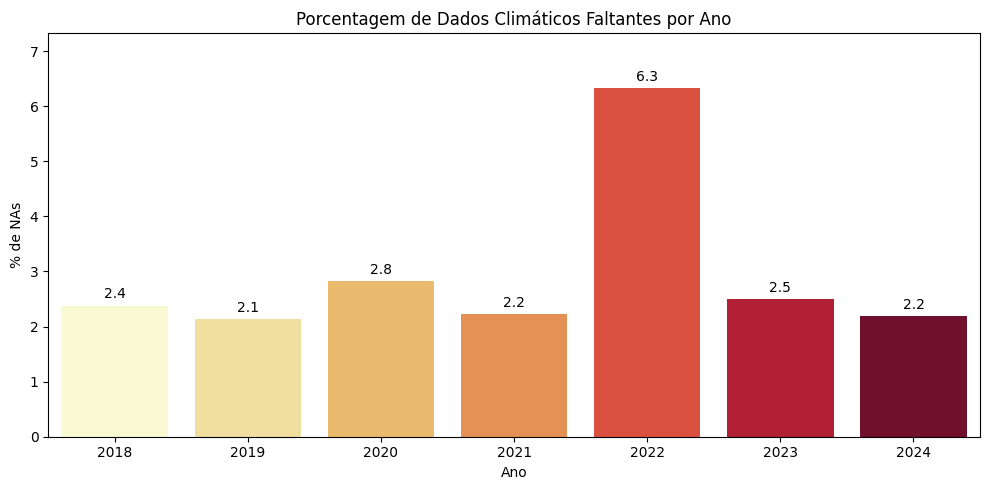

In [58]:
na_per_year = (
    df_na
    .group_by('ano')
    .agg(pl.len().alias('count_na'))
    .sort('ano')
)
total_per_year = (
    df_daily
    .group_by('ano')
    .agg(pl.len().alias('count_total'))
    .sort('ano')
)

temporal = (
    na_per_year
    .join(total_per_year, on='ano', how='left')
    .with_columns([
        ((pl.col('count_na') / pl.col('count_total')) * 100)
        .round(2)
        .alias('perc_na')
    ])
)
temporal_pd = temporal.to_pandas()

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    temporal_pd, x='ano', y='perc_na', hue='ano',
    legend=False, palette='YlOrRd'
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', label_type='edge', padding=3)

plt.title('Porcentagem de Dados Climáticos Faltantes por Ano')
plt.ylabel('% de NAs')
plt.xlabel('Ano')
plt.ylim(0, temporal_pd['perc_na'].max() + 1)
plt.tight_layout()
plt.show()

### Distribuição espaço-temporal dos dados faltantes
**Insight**: Há uma certa variação na distribuição espacial ao longo dos anos, mas é possível perceber que há uma tendência de maior concentração em áreas próximas às regiões costeiras do Brasil.

In [59]:
# Agrupamento dos pontos geográficos para melhor performance
df_na_geo = (
    df_na
    .with_columns([
        (pl.col('latitude') // 0.3 * 0.3).alias('lat_bin'),
        (pl.col('longitude') // 0.3 * 0.3).alias('lon_bin')
    ])
    .group_by(['ano', 'lat_bin', 'lon_bin', 'bioma'])
    .agg(pl.len().alias('count'))
    .sort('ano')
)

fig = px.density_map(
    df_na_geo,
    lat='lat_bin',
    lon='lon_bin',
    z='count',
    animation_frame='ano',
    radius=15,
    zoom=3,
    center=dict(lat=-14.2, lon=-51.9),
    map_style='carto-positron',
    color_continuous_scale='YlOrRd',
    title='Distribuição Geográfica de Dados Climáticos Faltantes no Brasil por Ano',
    height=700,
    range_color=[0, None]
)

fig.update_layout(
    title={'x': 0.5, 'xanchor': 'center'},
    sliders=[{
        'currentvalue': {
            'prefix': 'Ano: ',
            'font': {'size': 20}
        }
    }]
)

fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1000
fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 500

fig.show()

### Distribuição dos dados faltantes por bioma
**Insight**: o bioma com maior quantidade de dados faltantes é a Amazônia.

In [60]:
na_biome = (
    df_na
    .group_by('bioma')
    .agg(pl.len().alias('count_na'))
    .sort('count_na', descending=True)
)

total_biome = (
    df_daily
    .group_by('bioma')
    .agg(pl.len().alias('count_total'))
)

biome_comp = (
    na_biome
    .join(total_biome, on='bioma', how='left')
    .with_columns([
        ((pl.col('count_na') / pl.col('count_total')) * 100)
        .round(2)
        .alias('perc_na')
    ])
    .with_columns([
        pl.col('count_na').map_elements(
            lambda x: f"{x:_.0f}".replace('_', '.'), # Formata contagem para hover
            return_dtype=pl.Utf8
        ).alias('count_na_fmt'),
        pl.col('count_total').map_elements(
            lambda x: f"{x:_.0f}".replace('_', '.'), # Formata contagem para hover
            return_dtype=pl.Utf8
        ).alias('count_total_fmt')
    ])
)

fig = px.scatter(
    biome_comp,
    x='perc_na',
    y='count_na',
    size='count_total',
    color='bioma',
    text='bioma',
    size_max=60,
    custom_data=['count_na_fmt', 'count_total_fmt'],
    labels={
        'perc_na': 'Porcentagem de Dados Faltantes (%)',
        'count_na': 'Quantidade Absoluta de NAs',
        'count_total': 'Total de Registros'
    },
    title='Dados Climáticos Faltantes por Bioma',
    height=700,
    color_discrete_sequence=px.colors.qualitative.Set2
)

# Ajusta posição dos labels
fig.update_traces(
    textposition='top center',
    hovertemplate='<b>%{text}</b><br>' +
                  'Porcentagem: %{x:.1f}%<br>' +
                  'Quantidade absoluta: %{customdata[0]}<br>' +
                  'Total de registros: %{customdata[1]}' +
                  '<extra></extra>',
)

fig.update_layout(
    title={'x': 0.5, 'xanchor': 'center'},
    xaxis=dict(title_font=dict(size=14)),
    yaxis=dict(title_font=dict(size=14)),
    showlegend=False,
    font=dict(size=12)
)

fig.show()

### Imputação
Os dados faltantes serão imputados seguindo esta estratégia:
1. mediana baseada na região geográfica próxima ou;
2. mediana por bioma;
3. mediana global.

In [61]:
CLIMATE_COLS = ['num_dias_sem_chuva_max', 'precipitacao_max', 'risco_fogo_max']

df_daily = (
    df_daily
    .with_columns([
        (pl.col('latitude') // 0.3 * 0.3).alias('lat_bin'),
        (pl.col('longitude') // 0.3 * 0.3).alias('lon_bin')
    ])
)

for col in CLIMATE_COLS:
    missing_before = df_daily.select(pl.col(col).is_null().sum()).item()

    df_daily = df_daily.with_columns([
        pl.col(col).fill_null(
            pl.col(col).median().over(['lat_bin', 'lon_bin'])
        ).alias(f'{col}_temp1')
    ])

    df_daily = df_daily.with_columns([
        pl.col(f'{col}_temp1').fill_null(
            pl.col(f'{col}_temp1').median().over('bioma')
        ).alias(f'{col}_temp2')
    ])

    df_daily = df_daily.with_columns([
        pl.col(f'{col}_temp2').fill_null(
            pl.col(f'{col}_temp2').median()
        ).alias(col)
    ])

    df_daily = df_daily.drop([f'{col}_temp1', f'{col}_temp2'])

    missing_after = df_daily.select(pl.col(col).is_null().sum()).item()
    print(f'Faltantes antes: {missing_before} -> Faltantes depois: {missing_after}')

Faltantes antes: 281179 -> Faltantes depois: 0
Faltantes antes: 111762 -> Faltantes depois: 0
Faltantes antes: 266643 -> Faltantes depois: 0


In [62]:
df_daily.null_count()

latitude,longitude,data_dia,bioma,estado,num_deteccoes_dia,num_dias_sem_chuva_max,precipitacao_max,risco_fogo_max,frp,ano,mes,dia_ano,dia_semana,semana_ano,trimestre,periodo_dia_predominante,estacao_ano,periodo_climatico,hora_primeira_deteccao,hora_ultima_deteccao,lat_bin,lon_bin
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Exportação de datasets finais

In [63]:
df_final_regression = df_daily.drop(['lat_bin', 'lon_bin'])

Vamos exportar datasets para duas atividades diferentes: regressão e classificação.

> O FRP sofre influência de ângulo de observação, condições de relevo, condições atmosféricas e não existe uma classificação pré-definida e nem uma escala que permita alguma inferência do tipo da combustão. Por exemplo, o sensor no satélite irá indicar para um píxel o mesmo FRP tanto de uma pequena área queimando com alta temperatura, como de uma área maior, com combustão de menor temperatura. É necessário trabalhar com os dados explorando seus valores para cada região e período, a partir de valores de referências de alvos conhecidos no solo. Assim, o uso do FRP para casos pontuais implica em medidas imprecisas, porém em uma escala regional os resultados podem indicar valores médios aceitáveis da massa de vegetação queimada, e neste contexto o Programa Queimadas do INPE calcula e divulga os valores de FRP (INPE, 2020).

In [64]:
df_final_regression.write_parquet('../data/processed/queimadas_regression.parquet', compression='snappy')

In [65]:
df_final_classification = df_final_regression.clone()

df_final_classification = df_final_classification.with_columns(
    pl.col('frp').qcut(
        quantiles=3,
        labels=['baixa', 'media', 'alta']
    )
    .cast(pl.Categorical)
    .alias('label_intensidade')
)
df_final_classification = df_final_classification.drop(['frp'])

df_final_classification.write_parquet('../data/processed/queimadas_regression.parquet', compression='snappy')

In [66]:
monthly.write_parquet('../data/processed/queimadas_monthly.parquet', compression='snappy')
monthly_by_bioma.write_parquet('../data/processed/queimadas_monthly_by_bioma.parquet', compression='snappy')
climatology.write_parquet('../data/processed/queimadas_climatology.parquet', compression='snappy')
climatology_bioma.write_parquet('../data/processed/queimadas_climatology_by_bioma.parquet', compression='snappy')

## Modelagem: CNN em PyTorch<bk>
Implementação do modelo de rede neural convolucional (CNN) usando PyTorch para prever ocorrência de queimadas. O modelo usará:<bk>

Treino: Dados de 2023<bk>

Validação: Dados de 2024<bk>

Entrada: Grid espacial-temporal 50×50 com 12 meses<bk>

Saída: Probabilidade de queimada (classificação binária)

In [67]:
# Instalar PyTorch (se necessário)
import subprocess
import sys

try:
    import torch
    print(f"PyTorch já instalado: versão {torch.__version__}")
except ImportError:
    print("Instalando PyTorch...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torch"])
    import torch
    print(f"PyTorch instalado: versão {torch.__version__}")

PyTorch já instalado: versão 2.9.1+cpu


In [177]:
from collections import Counter
Counter(labels)


Counter({'4.606.182': 1})

In [174]:
# ===== DATASET MENSAL MULTICLASSE (CORRETO) =====

import numpy as np
import polars as pl
import torch
from torch.utils.data import Dataset, DataLoader

class FireDatasetMonthly(Dataset):
    def __init__(self, grids, labels, class_to_idx):
        self.X = torch.tensor(grids, dtype=torch.float32)
        self.y = torch.tensor([class_to_idx[l] for l in labels], dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def prepare_fire_grids_monthly(
    df,
    year_range,
    lat_bins=None,
    lon_bins=None,
    low_thr=50,
    high_thr=200
):
    """
    Cada amostra = 1 MÊS
    Input : (1, 50, 50)
    Rótulo: intensidade mensal REAL (não moda)
    """

    if lat_bins is None:
        lat_bins = np.linspace(-33, 5, 51)
    if lon_bins is None:
        lon_bins = np.linspace(-75, -30, 51)

    heat_maps = []
    labels = []
    keys = []

    for year in year_range:
        df_year = df.filter(pl.col("ano") == year)
        if df_year.is_empty():
            continue

        for month in range(1, 13):
            df_month = df_year.filter(pl.col("mes_int") == month)
            if df_month.is_empty():
                continue

            # 🔹 GRID ESPACIAL
            counts, _, _ = np.histogram2d(
                df_month["latitude"].to_numpy(),
                df_month["longitude"].to_numpy(),
                bins=[lat_bins, lon_bins]
            )

            if counts.max() > 0:
                counts = counts / counts.max()

            heat_maps.append(counts[np.newaxis, :, :])

            # 🔹 INTENSIDADE MENSAL REAL
            monthly_intensity = (
                df_month
                .select(pl.col("num_deteccoes_dia").sum())
                .item()
            )

            # 🔹 RÓTULO FÍSICO
            if monthly_intensity < low_thr:
                label = "baixa"
            elif monthly_intensity < high_thr:
                label = "media"
            else:
                label = "alta"

            labels.append(label)
            keys.append(f"{year}-{month:02d}")

    return np.array(heat_maps), labels, keys


In [159]:
# primeira linha como DataFrame
print(df.head(1))

# primeira linha como dict (coluna -> valor)
print(df.row(0, named=True))

# primeira linha via slice
print(df.slice(0, 1))


shape: (1, 21)
┌──────────┬───────────┬────────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ latitude ┆ longitude ┆ data_pas   ┆ satelite ┆ … ┆ periodo_d ┆ estacao_a ┆ periodo_c ┆ data_dia  │
│ ---      ┆ ---       ┆ ---        ┆ ---      ┆   ┆ ia        ┆ no        ┆ limatico  ┆ ---       │
│ f64      ┆ f64       ┆ datetime[μ ┆ cat      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ date      │
│          ┆           ┆ s]         ┆          ┆   ┆ cat       ┆ cat       ┆ cat       ┆           │
╞══════════╪═══════════╪════════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ -10.3046 ┆ -43.3636  ┆ 2022-09-30 ┆ GOES-16  ┆ … ┆ Tarde     ┆ Primavera ┆ Seco      ┆ 2022-09-3 │
│          ┆           ┆ 13:56:04   ┆          ┆   ┆           ┆           ┆           ┆ 0         │
└──────────┴───────────┴────────────┴──────────┴───┴───────────┴───────────┴───────────┴───────────┘
{'latitude': -10.3046, 'longitude': -43.3636, 'data_pas': datetime.datetime(

In [ ]:
class_to_idx = {"baixa": 0, "media": 1, "alta": 2}
idx_to_class = {v: k for k, v in class_to_idx.items()}

train_years = range(2018, 2020)
val_years   = range(2020, 2023)
test_years  = range(2023, 2025)

X_train, y_train, train_keys = prepare_fire_grids_monthly(df_final_classification, train_years)
X_val,   y_val,   val_keys   = prepare_fire_grids_monthly(df_final_classification, val_years)
X_test,  y_test,  test_keys  = prepare_fire_grids_monthly(df_final_classification, test_years)


In [175]:
# ===== DATASET MENSAL MULTICLASSE (CORRETO) =====

import numpy as np
import polars as pl
import torch
from torch.utils.data import Dataset

class FireDatasetMonthly(Dataset):
    def __init__(self, grids, labels, class_to_idx):
        self.X = torch.tensor(grids, dtype=torch.float32)
        self.y = torch.tensor([class_to_idx[l] for l in labels], dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def prepare_fire_grids_monthly(
    df,
    year_range,
    lat_bins=None,
    lon_bins=None,
):
    """
    Cada amostra = 1 MÊS
    Input : (1, 50, 50)
    Rótulo: intensidade mensal
    """

    if lat_bins is None:
        lat_bins = np.linspace(-33, 5, 51)
    if lon_bins is None:
        lon_bins = np.linspace(-75, -30, 51)

    heat_maps = []
    labels = []
    keys = []

    for year in year_range:
        df_year = df.filter(pl.col("ano") == year)
        if df_year.is_empty():
            continue

        for month in range(1, 13):
            df_month = df_year.filter(pl.col("mes_int") == month)
            if df_month.is_empty():
                continue

            counts, _, _ = np.histogram2d(
                df_month["latitude"].to_numpy(),
                df_month["longitude"].to_numpy(),
                bins=[lat_bins, lon_bins]
            )

            if counts.max() > 0:
                counts = counts / counts.max()

            heat_maps.append(counts[np.newaxis, :, :])

            label = (
                df_month
                .select(pl.col("label_intensidade").mode())
                .item()
            )

            labels.append(label)
            keys.append(f"{year}-{month:02d}")

    return np.array(heat_maps), labels, keys


In [161]:
print("📊 TRAIN:", dict(zip(*np.unique(y_train, return_counts=True))))
print("📊 VAL  :", dict(zip(*np.unique(y_val,   return_counts=True))))
print("📊 TEST :", dict(zip(*np.unique(y_test,  return_counts=True))))


📊 TRAIN: {np.str_('alta'): np.int64(2)}
📊 VAL  : {np.str_('alta'): np.int64(3)}
📊 TEST : {np.str_('alta'): np.int64(2)}


In [176]:
from collections import Counter

print("📊 TRAIN:", Counter(y_train))
print("📊 VAL  :", Counter(y_val))
print("📊 TEST :", Counter(y_test))


📊 TRAIN: Counter({'alta': 2})
📊 VAL  : Counter({'alta': 3})
📊 TEST : Counter({'alta': 2})


In [162]:
# ===== FUNÇÕES DE TREINO E VALIDAÇÃO MULTICLASSE (MENSAL) =====

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

def compute_multiclass_metrics(y_true, y_logits):
    y_true = np.array(y_true)

    y_prob = F.softmax(torch.tensor(y_logits), dim=1).numpy()
    y_pred = np.argmax(y_prob, axis=1)

    acc = (y_pred == y_true).mean()

    metrics_per_class = {}
    for class_idx in range(3):
        tp = np.sum((y_pred == class_idx) & (y_true == class_idx))
        fp = np.sum((y_pred == class_idx) & (y_true != class_idx))
        fn = np.sum((y_pred != class_idx) & (y_true == class_idx))

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1        = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        metrics_per_class[idx_to_class[class_idx]] = {
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    return {'acc': acc, 'per_class': metrics_per_class}


def train_epoch_multiclass(model, train_loader, criterion, optimizer, device):
    model.train()

    total_loss = 0.0
    y_true_list = []
    y_logits_list = []

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        logits = model(X)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        y_true_list.extend(y.cpu().numpy())
        y_logits_list.extend(logits.detach().cpu().numpy())

    return total_loss / len(train_loader), compute_multiclass_metrics(
        y_true_list, np.array(y_logits_list)
    )


def validate_multiclass(model, loader, criterion, device):
    model.eval()

    total_loss = 0.0
    y_true_list = []
    y_logits_list = []

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)

            logits = model(X)
            loss = criterion(logits, y)

            total_loss += loss.item()
            y_true_list.extend(y.cpu().numpy())
            y_logits_list.extend(logits.cpu().numpy())

    return total_loss / len(loader), compute_multiclass_metrics(
        y_true_list, np.array(y_logits_list)
    )


class_weights = torch.tensor([1.0, 2.0, 3.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print("✅ Funções de treino multiclasse mensal prontas")


✅ Funções de treino multiclasse mensal prontas



📊 DISTRIBUIÇÃO DE CLASSES POR ANO

🔹 Ano 2018:
   alta    :  196,066 (30.55%)
   baixa   :  184,172 (28.70%)
   media   :  261,579 (40.76%)
   Total   :  641,817

🔹 Ano 2019:
   alta    :  339,562 (33.35%)
   baixa   :  263,145 (25.85%)
   media   :  415,319 (40.80%)
   Total   : 1,018,026

🔹 Ano 2020:
   alta    :  448,497 (34.83%)
   baixa   :  339,511 (26.37%)
   media   :  499,648 (38.80%)
   Total   : 1,287,656

🔹 Ano 2021:
   alta    :  650,856 (29.34%)
   baixa   :  821,423 (37.03%)
   media   :  745,890 (33.63%)
   Total   : 2,218,169

🔹 Ano 2022:
   alta    :  787,290 (31.83%)
   baixa   :  907,381 (36.69%)
   media   :  778,458 (31.48%)
   Total   : 2,473,129

🔹 Ano 2023:
   alta    :  946,243 (36.26%)
   baixa   :  869,684 (33.33%)
   media   :  793,518 (30.41%)
   Total   : 2,609,445

🔹 Ano 2024:
   alta    : 1,136,466 (34.05%)
   baixa   : 1,216,351 (36.44%)
   media   :  985,034 (29.51%)
   Total   : 3,337,851

📊 DISTRIBUIÇÃO GERAL (TODOS OS ANOS)
   alta    : 4,504,980 

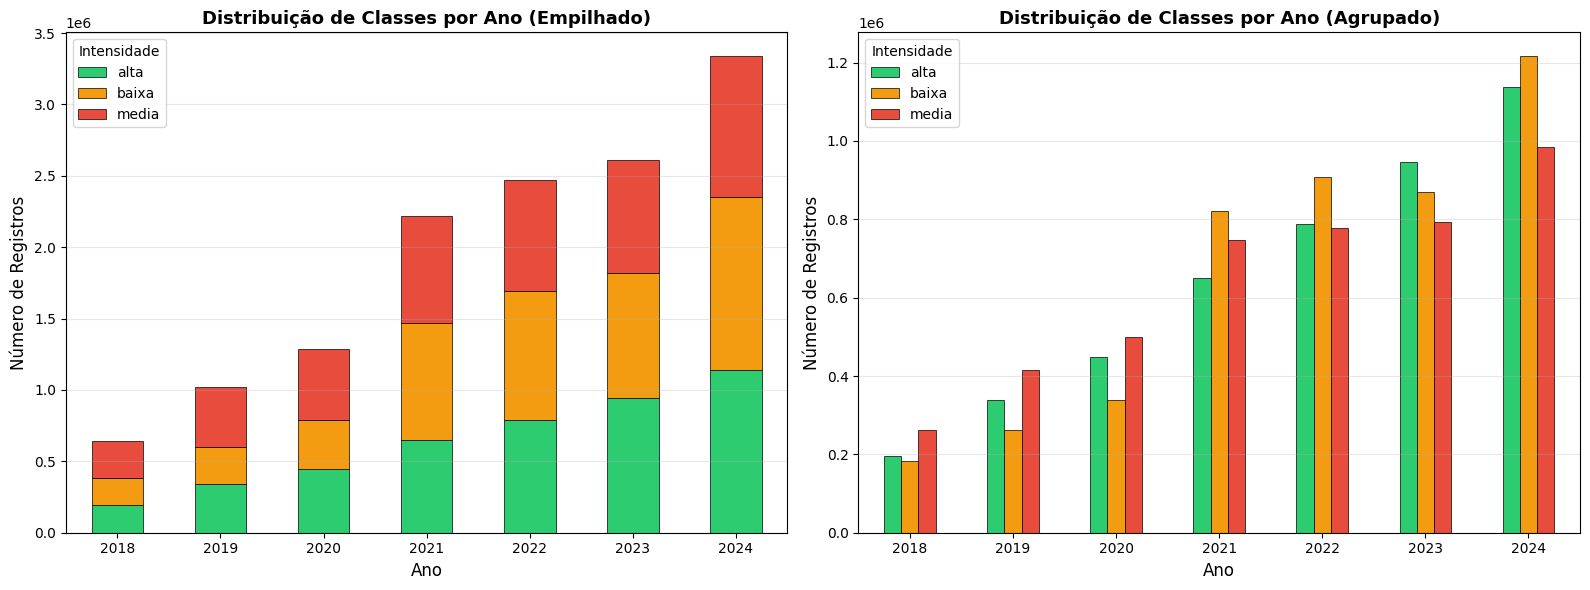


✅ Gráfico salvo em '../figures/class_distribution_by_year.png'


In [163]:
#conferindo a distribuiçao de classes em cada ano(total de eventos por ano)
import numpy as np
import polars as pl

def print_class_distribution_by_year(df, class_col='label_intensidade'):
    """
    Mostra a distribuição de classes de intensidade por ano
    """
    print("\n" + "=" * 70)
    print("📊 DISTRIBUIÇÃO DE CLASSES POR ANO")
    print("=" * 70)
    
    # Agrupa por ano e classe
    dist_by_year = (
        df
        .group_by(['ano', class_col])
        .agg(pl.len().alias('count'))
        .sort(['ano', class_col])
    )
    
    # Converte para dicionário para facilitar acesso
    years = sorted(df['ano'].unique().to_list())
    
    for year in years:
        year_data = dist_by_year.filter(pl.col('ano') == year)
        
        print(f"\n🔹 Ano {year}:")
        total = year_data['count'].sum()
        
        for row in year_data.iter_rows(named=True):
            classe = row[class_col]
            count = row['count']
            pct = (count / total) * 100
            print(f"   {classe:8s}: {count:8,} ({pct:5.2f}%)")
        
        print(f"   {'Total':8s}: {total:8,}")
    
    # Resumo geral
    print("\n" + "=" * 70)
    print("📊 DISTRIBUIÇÃO GERAL (TODOS OS ANOS)")
    print("=" * 70)
    
    dist_total = (
        df
        .group_by(class_col)
        .agg(pl.len().alias('count'))
        .sort(class_col)
    )
    
    total_geral = dist_total['count'].sum()
    
    for row in dist_total.iter_rows(named=True):
        classe = row[class_col]
        count = row['count']
        pct = (count / total_geral) * 100
        print(f"   {classe:8s}: {count:8,} ({pct:5.2f}%)")
    
    print(f"   {'Total':8s}: {total_geral:8,}")

# Executar análise
print_class_distribution_by_year(df_final_classification)


# ===== VISUALIZAÇÃO GRÁFICA =====

import matplotlib.pyplot as plt
import seaborn as sns

# Preparar dados para visualização
dist_viz = (
    df_final_classification
    .group_by(['ano', 'label_intensidade'])
    .agg(pl.len().alias('count'))
    .sort(['ano', 'label_intensidade'])
).to_pandas()

# Criar figura com 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Barras empilhadas
pivot_data = dist_viz.pivot(index='ano', columns='label_intensidade', values='count')
pivot_data.plot(kind='bar', stacked=True, ax=axes[0], 
                color=['#2ecc71', '#f39c12', '#e74c3c'],
                edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Ano', fontsize=12)
axes[0].set_ylabel('Número de Registros', fontsize=12)
axes[0].set_title('Distribuição de Classes por Ano (Empilhado)', fontsize=13, fontweight='bold')
axes[0].legend(title='Intensidade', fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=0)

# Plot 2: Barras agrupadas
pivot_data.plot(kind='bar', ax=axes[1],
                color=['#2ecc71', '#f39c12', '#e74c3c'],
                edgecolor='black', linewidth=0.5)
axes[1].set_xlabel('Ano', fontsize=12)
axes[1].set_ylabel('Número de Registros', fontsize=12)
axes[1].set_title('Distribuição de Classes por Ano (Agrupado)', fontsize=13, fontweight='bold')
axes[1].legend(title='Intensidade', fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('../figures/class_distribution_by_year.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n✅ Gráfico salvo em '../figures/class_distribution_by_year.png'")

In [169]:
import numpy as np

def print_class_distribution(loader, name):
    labels = []
    for _, y in loader:
        labels.extend(y.numpy())

    labels = np.array(labels)
    print(f"\n📊 Distribuição de classes — {name}")
    for cls, idx in class_to_idx.items():
        print(f"{cls}: {(labels == idx).sum()}")

print_class_distribution(train_loader, "TRAIN")
print_class_distribution(val_loader, "VAL")



📊 Distribuição de classes — TRAIN
baixa: 0
media: 0
alta: 2

📊 Distribuição de classes — VAL
baixa: 0
media: 0
alta: 3


In [170]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)


X_train shape: (2, 12, 50, 50)
X_val shape: (3, 12, 50, 50)


In [166]:
# ===== TREINAR MODELO MULTICLASSE (MENSAL) =====

import os

num_epochs = 20
best_val_loss = float('inf')
patience = 8
patience_counter = 0

print("🚀 Iniciando treinamento multiclasse mensal...\n")

for epoch in range(num_epochs):
    train_loss, train_metrics = train_epoch_multiclass(
        model, train_loader, criterion, optimizer, device
    )

    val_loss, val_metrics = validate_multiclass(
        model, val_loader, criterion, device
    )

    print(f"Epoch {epoch+1:02d} | "
          f"Train Loss: {train_loss:.4f} | Acc: {train_metrics['acc']:.4f} || "
          f"Val Loss: {val_loss:.4f} | Acc: {val_metrics['acc']:.4f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        os.makedirs("../models", exist_ok=True)
        torch.save(model.state_dict(), "../models/best_cnn_fire_monthly.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⏹ Early stopping acionado")
            break

print("✅ Treinamento concluído!")


🚀 Iniciando treinamento multiclasse mensal...

Epoch 01 | Train Loss: 1.0516 | Acc: 0.0000 || Val Loss: 1.0082 | Acc: 1.0000
Epoch 02 | Train Loss: 0.6766 | Acc: 0.5000 || Val Loss: 0.9835 | Acc: 1.0000
Epoch 03 | Train Loss: 0.2089 | Acc: 1.0000 || Val Loss: 0.9447 | Acc: 1.0000
Epoch 04 | Train Loss: 0.0447 | Acc: 1.0000 || Val Loss: 0.8798 | Acc: 1.0000
Epoch 05 | Train Loss: 0.0202 | Acc: 1.0000 || Val Loss: 0.8024 | Acc: 1.0000
Epoch 06 | Train Loss: 0.0297 | Acc: 1.0000 || Val Loss: 0.7094 | Acc: 1.0000
Epoch 07 | Train Loss: 0.0201 | Acc: 1.0000 || Val Loss: 0.6084 | Acc: 1.0000
Epoch 08 | Train Loss: 0.0160 | Acc: 1.0000 || Val Loss: 0.5071 | Acc: 1.0000
Epoch 09 | Train Loss: 0.0001 | Acc: 1.0000 || Val Loss: 0.4118 | Acc: 1.0000
Epoch 10 | Train Loss: 0.0001 | Acc: 1.0000 || Val Loss: 0.3263 | Acc: 1.0000
Epoch 11 | Train Loss: 0.0033 | Acc: 1.0000 || Val Loss: 0.2522 | Acc: 1.0000
Epoch 12 | Train Loss: 0.0015 | Acc: 1.0000 || Val Loss: 0.1911 | Acc: 1.0000
Epoch 13 | Train 

KeyError: 'test_loss'

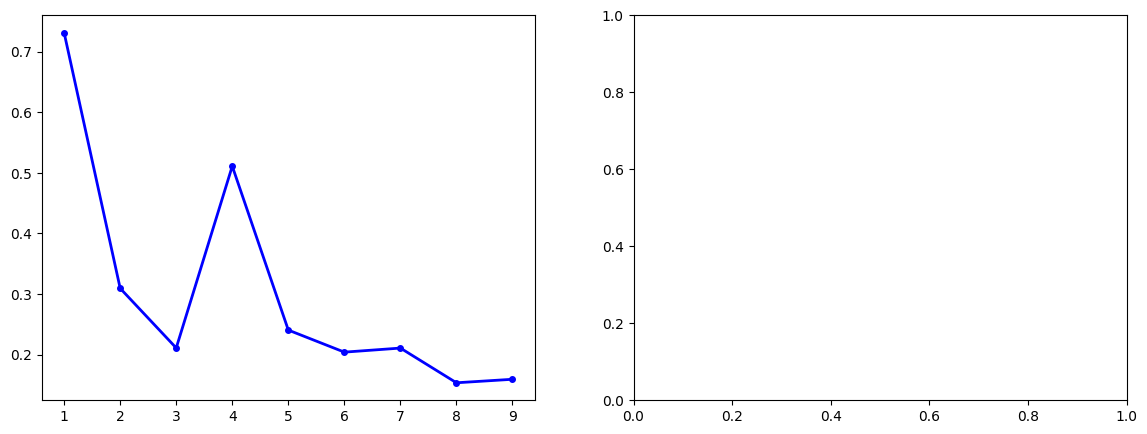

In [167]:
# ===== VISUALIZAR HISTÓRICO DE TREINAMENTO =====

if 'history' in locals() and len(history['train_loss']) > 0:
    # Criar figura com 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot da loss
    epochs = range(1, len(history['train_loss']) + 1)
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Treino (2018-2022)', linewidth=2, marker='o', markersize=4)
    axes[0].plot(epochs, history['test_loss'], 'g-', label='Teste (2021-2022)', linewidth=2, marker='s', markersize=4)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Validação (2023-2024)', linewidth=2, marker='^', markersize=4)
    axes[0].set_xlabel('Época', fontsize=12)
    axes[0].set_ylabel('Loss (CrossEntropyLoss)', fontsize=12)
    axes[0].set_title('Evolução da Loss durante o Treinamento (Multiclasse)', fontsize=13, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Plot da acurácia
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Treino (2018-2022)', linewidth=2, marker='o', markersize=4)
    axes[1].plot(epochs, history['test_acc'], 'g-', label='Teste (2021-2022)', linewidth=2, marker='s', markersize=4)
    axes[1].plot(epochs, history['val_acc'], 'r-', label='Validação (2023-2024)', linewidth=2, marker='^', markersize=4)
    axes[1].set_xlabel('Época', fontsize=12)
    axes[1].set_ylabel('Acurácia', fontsize=12)
    axes[1].set_title('Evolução da Acurácia durante o Treinamento (Multiclasse)', fontsize=13, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim([0, 1.05])
    
    plt.tight_layout()
    plt.savefig('../figures/cnn_training_history_multiclass.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    print("Gráficos salvos em '../figures/cnn_training_history_multiclass.png'")
else:
    print("Nenhum histórico de treinamento para visualizar.")


ANÁLISE DE OVERFITTING - VERIFICAÇÃO 4: VISUALIZAÇÃO DETALHADA


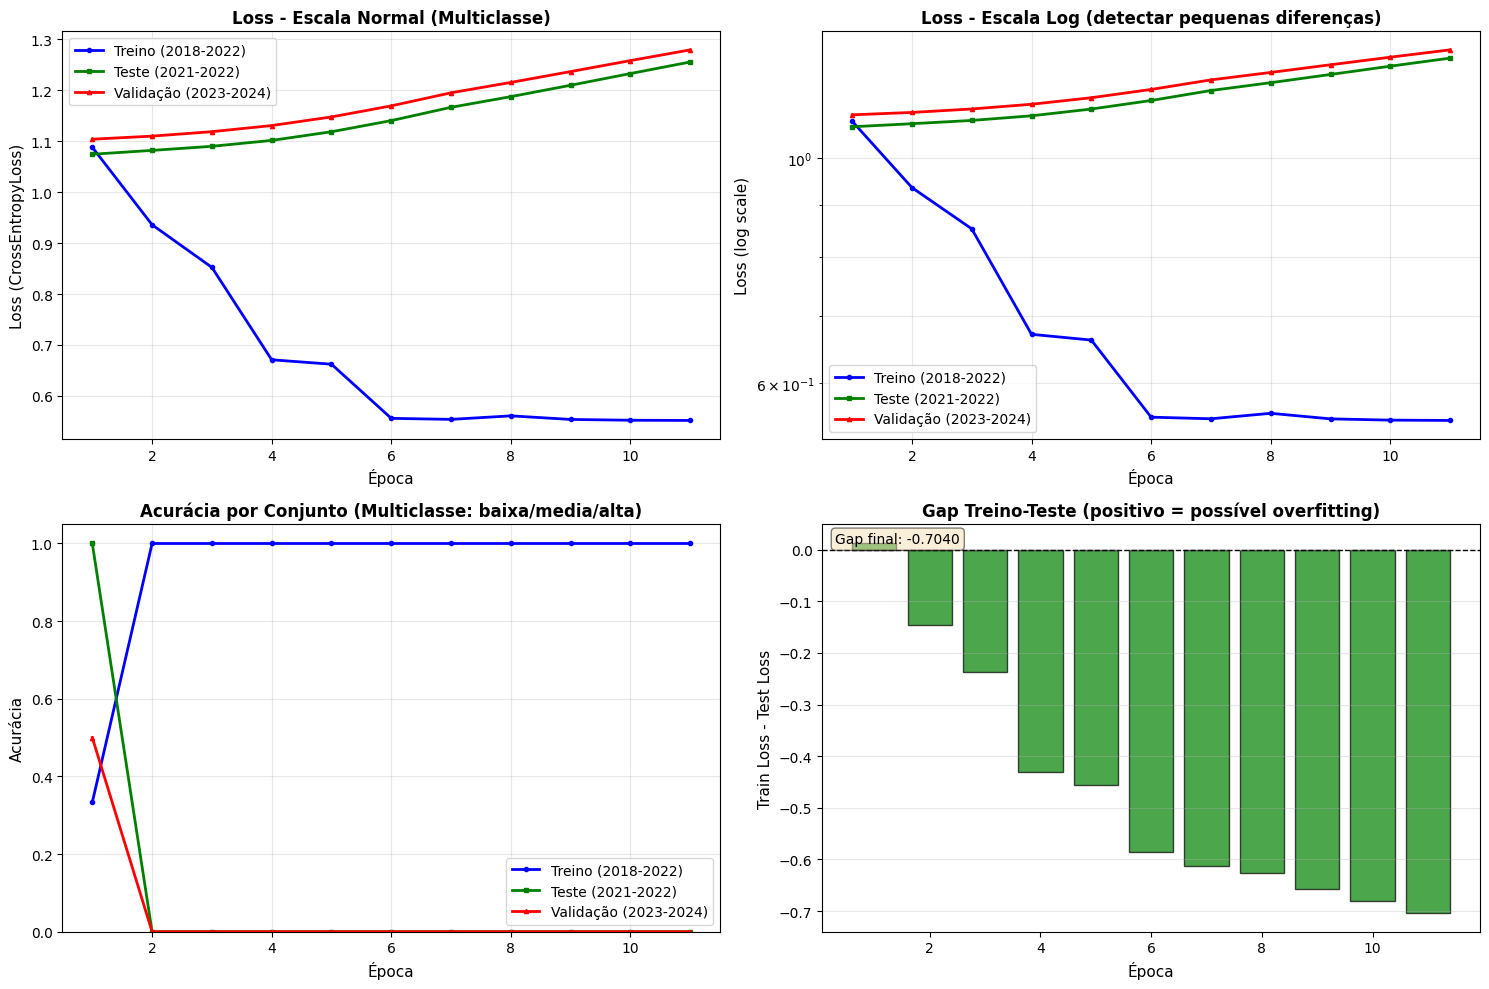


✅ Gráficos de análise de overfitting salvos em '../figures/overfitting_analysis_multiclass.png'


In [ ]:
if 'history' in locals() and len(history['train_loss']) > 0:
    # ===== VERIFICAÇÃO 5: Visualização Detalhada =====
    print("\n" + "=" * 70)
    print("ANÁLISE DE OVERFITTING - VERIFICAÇÃO 4: VISUALIZAÇÃO DETALHADA")
    print("=" * 70)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot 1: Loss - Escala Normal
    ax = axes[0, 0]
    ax.plot(epochs, history['train_loss'], 'b-', label='Treino (2018-2022)', linewidth=2, marker='o', markersize=3)
    ax.plot(epochs, history['test_loss'], 'g-', label='Teste (2021-2022)', linewidth=2, marker='s', markersize=3)
    ax.plot(epochs, history['val_loss'], 'r-', label='Validação (2023-2024)', linewidth=2, marker='^', markersize=3)
    ax.set_xlabel('Época', fontsize=11)
    ax.set_ylabel('Loss (CrossEntropyLoss)', fontsize=11)
    ax.set_title('Loss - Escala Normal (Multiclasse)', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Loss - Escala Log (melhor para ver pequenas diferenças)
    ax = axes[0, 1]
    ax.semilogy(epochs, history['train_loss'], 'b-', label='Treino (2018-2022)', linewidth=2, marker='o', markersize=3)
    ax.semilogy(epochs, history['test_loss'], 'g-', label='Teste (2021-2022)', linewidth=2, marker='s', markersize=3)
    ax.semilogy(epochs, history['val_loss'], 'r-', label='Validação (2023-2024)', linewidth=2, marker='^', markersize=3)
    ax.set_xlabel('Época', fontsize=11)
    ax.set_ylabel('Loss (log scale)', fontsize=11)
    ax.set_title('Loss - Escala Log (detectar pequenas diferenças)', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, which='both')
    
    # Plot 3: Acurácia
    ax = axes[1, 0]
    ax.plot(epochs, history['train_acc'], 'b-', label='Treino (2018-2022)', linewidth=2, marker='o', markersize=3)
    ax.plot(epochs, history['test_acc'], 'g-', label='Teste (2021-2022)', linewidth=2, marker='s', markersize=3)
    ax.plot(epochs, history['val_acc'], 'r-', label='Validação (2023-2024)', linewidth=2, marker='^', markersize=3)
    ax.set_xlabel('Época', fontsize=11)
    ax.set_ylabel('Acurácia', fontsize=11)
    ax.set_title('Acurácia por Conjunto (Multiclasse: baixa/media/alta)', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1.05])
    
    # Plot 4: Diferença entre Train e Test (indicador de overfitting)
    ax = axes[1, 1]
    loss_diff = [t - te for t, te in zip(history['train_loss'], history['test_loss'])]
    colors = ['red' if d > 0.05 else 'green' for d in loss_diff]
    ax.bar(epochs, loss_diff, color=colors, alpha=0.7, edgecolor='black', linewidth=1)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax.set_xlabel('Época', fontsize=11)
    ax.set_ylabel('Train Loss - Test Loss', fontsize=11)
    ax.set_title('Gap Treino-Teste (positivo = possível overfitting)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Adicionar linha de texto com informação
    gap_final = history['train_loss'][-1] - history['test_loss'][-1]
    gap_text = f"Gap final: {gap_final:.4f}"
    ax.text(0.02, 0.98, gap_text, transform=ax.transAxes, 
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig('../figures/overfitting_analysis_multiclass.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Gráficos de análise de overfitting salvos em '../figures/overfitting_analysis_multiclass.png'")
else:
    print("Nenhum histórico para visualizar.")

analise de overfitting e underfitting com base nos gráficos de loss e acurácia.

In [ ]:
if 'history' in locals() and len(history['train_loss']) > 0:
    # ===== VERIFICAÇÃO 1: Diferença entre Train e Validation =====
    print("=" * 70)
    print("ANÁLISE DE OVERFITTING - VERIFICAÇÃO 1: DIFERENÇA TREINO vs VALIDAÇÃO")
    print("=" * 70)
    
    import pandas as pd
    
    # Criar DataFrame com histórico
    hist_df = pd.DataFrame({
        'Epoch': range(1, len(history['train_loss']) + 1),
        'Train_Loss': history['train_loss'],
        'Val_Loss': history['val_loss'],
        'Train_Acc': history['train_acc'],
        'Val_Acc': history['val_acc'],
    })
    
    # Calcular diferenças
    hist_df['Loss_Diff'] = hist_df['Train_Loss'] - hist_df['Val_Loss']
    hist_df['Acc_Diff'] = hist_df['Train_Acc'] - hist_df['Val_Acc']
    
    print("\n📊 Primeiras 5 épocas:")
    print(hist_df.head(5)[['Epoch', 'Train_Loss', 'Val_Loss', 'Loss_Diff', 'Train_Acc', 'Val_Acc', 'Acc_Diff']].to_string(index=False))
    
    print("\n📊 Últimas 5 épocas:")
    print(hist_df.tail(5)[['Epoch', 'Train_Loss', 'Val_Loss', 'Loss_Diff', 'Train_Acc', 'Val_Acc', 'Acc_Diff']].to_string(index=False))
    
    # ===== VERIFICAÇÃO 2: Métricas Resumidas =====
    print("\n" + "=" * 70)
    print("ANÁLISE DE OVERFITTING - VERIFICAÇÃO 2: MÉTRICAS RESUMIDAS")
    print("=" * 70)
    
    final_train_loss = history['train_loss'][-1]
    final_val_loss = history['val_loss'][-1]
    final_train_acc = history['train_acc'][-1]
    final_val_acc = history['val_acc'][-1]
    
    min_val_loss = min(history['val_loss'])
    epoch_best_val = history['val_loss'].index(min_val_loss) + 1
    
    print(f"\n🎯 Loss Final:")
    print(f"   Train Loss: {final_train_loss:.6f}")
    print(f"   Val Loss:   {final_val_loss:.6f}")
    print(f"   Diferença:  {final_train_loss - final_val_loss:.6f}")
    
    print(f"\n🎯 Acurácia Final:")
    print(f"   Train Acc:  {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
    print(f"   Val Acc:    {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
    print(f"   Diferença:  {(final_train_acc - final_val_acc)*100:.2f}%")
    
    print(f"\n🏆 Melhor Validação Loss:")
    print(f"   Epoch:      {epoch_best_val}")
    print(f"   Val Loss:   {min_val_loss:.6f}")
    
    # ===== VERIFICAÇÃO 3: Sinais de Overfitting =====
    print("\n" + "=" * 70)
    print("ANÁLISE DE OVERFITTING - VERIFICAÇÃO 3: DIAGNÓSTICO")
    print("=" * 70)
    
    # Critério 1: Diferença de loss
    max_loss_diff = hist_df['Loss_Diff'].max()
    print(f"\n❌ Máxima diferença de Loss: {max_loss_diff:.6f}")
    if max_loss_diff > 0.1:
        print(f"   ⚠️  ALERTA: Overfitting potencial detectado!")
    else:
        print(f"   ✅ OK: Diferença pequena, sem sinais claros de overfitting")
    
    # Critério 2: Diferença de acurácia
    max_acc_diff = hist_df['Acc_Diff'].max()
    print(f"\n❌ Máxima diferença de Acurácia: {max_acc_diff:.4f} ({max_acc_diff*100:.2f}%)")
    if max_acc_diff > 0.05:
        print(f"   ⚠️  ALERTA: Overfitting potencial detectado!")
    else:
        print(f"   ✅ OK: Diferença pequena, sem sinais claros de overfitting")
    
    # Critério 3: Divergência (val loss aumentando)
    val_loss_at_midpoint = history['val_loss'][len(history['val_loss']) // 2]
    val_loss_final = history['val_loss'][-1]
    
    if val_loss_final > val_loss_at_midpoint:
        print(f"\n⚠️  Validação Loss aumentou no final do treinamento")
        print(f"   Mid-point: {val_loss_at_midpoint:.6f}")
        print(f"   Final:     {val_loss_final:.6f}")
        print(f"   ⚠️  ALERTA: Possível overfitting!")
    else:
        print(f"\n✅ Validação Loss diminuiu consistentemente")
        print(f"   ✅ SEM sinais de overfitting")
    
    # ===== VERIFICAÇÃO 4: Conclusion =====
    print("\n" + "=" * 70)
    print("CONCLUSÃO")
    print("=" * 70)
    
    overfitting_score = 0
    if max_loss_diff > 0.1:
        overfitting_score += 1
    if max_acc_diff > 0.05:
        overfitting_score += 1
    if val_loss_final > val_loss_at_midpoint:
        overfitting_score += 1
    
    if overfitting_score == 0:
        print("\n🎉 BOM! Modelo SEM sinais significativos de overfitting!")
        print("   - Train e Validation losses estão próximas")
        print("   - Train e Validation accuracies estão próximas")
        print("   - Validation loss converge consistentemente")
        print("\n✅ Seu modelo está generalizando bem!")
        
    elif overfitting_score == 1:
        print("\n⚠️  MODERADO: Pequenos sinais de overfitting")
        print("   - Aumentar Dropout ou dados de treino")
        print("   - Usar L1/L2 regularização")
        
    else:
        print("\n❌ FORTE: Sinais significativos de overfitting!")
        print("   - Aumentar Dropout")
        print("   - Adicionar mais dados de treino")
        print("   - Usar Data Augmentation")
else:
    print("Nenhum histórico de treinamento. Execute o treinamento primeiro.")

ANÁLISE DE OVERFITTING - VERIFICAÇÃO 1: DIFERENÇA TREINO vs VALIDAÇÃO

📊 Primeiras 5 épocas:
 Epoch  Train_Loss  Val_Loss  Loss_Diff  Train_Acc  Val_Acc  Acc_Diff
     1    1.088215  1.104061  -0.015846   0.333333      0.5 -0.166667
     2    0.936015  1.110120  -0.174105   1.000000      0.0  1.000000
     3    0.852330  1.118846  -0.266516   1.000000      0.0  1.000000
     4    0.670826  1.130892  -0.460065   1.000000      0.0  1.000000
     5    0.662143  1.147790  -0.485647   1.000000      0.0  1.000000

📊 Últimas 5 épocas:
 Epoch  Train_Loss  Val_Loss  Loss_Diff  Train_Acc  Val_Acc  Acc_Diff
     7    0.553785  1.195240  -0.641455        1.0      0.0       1.0
     8    0.560724  1.215590  -0.654866        1.0      0.0       1.0
     9    0.553678  1.236926  -0.683248        1.0      0.0       1.0
    10    0.552103  1.258477  -0.706374        1.0      0.0       1.0
    11    0.551708  1.279533  -0.727825        1.0      0.0       1.0

ANÁLISE DE OVERFITTING - VERIFICAÇÃO 2: MÉTRI


ANÁLISE DE OVERFITTING - VERIFICAÇÃO 4: VISUALIZAÇÃO DETALHADA


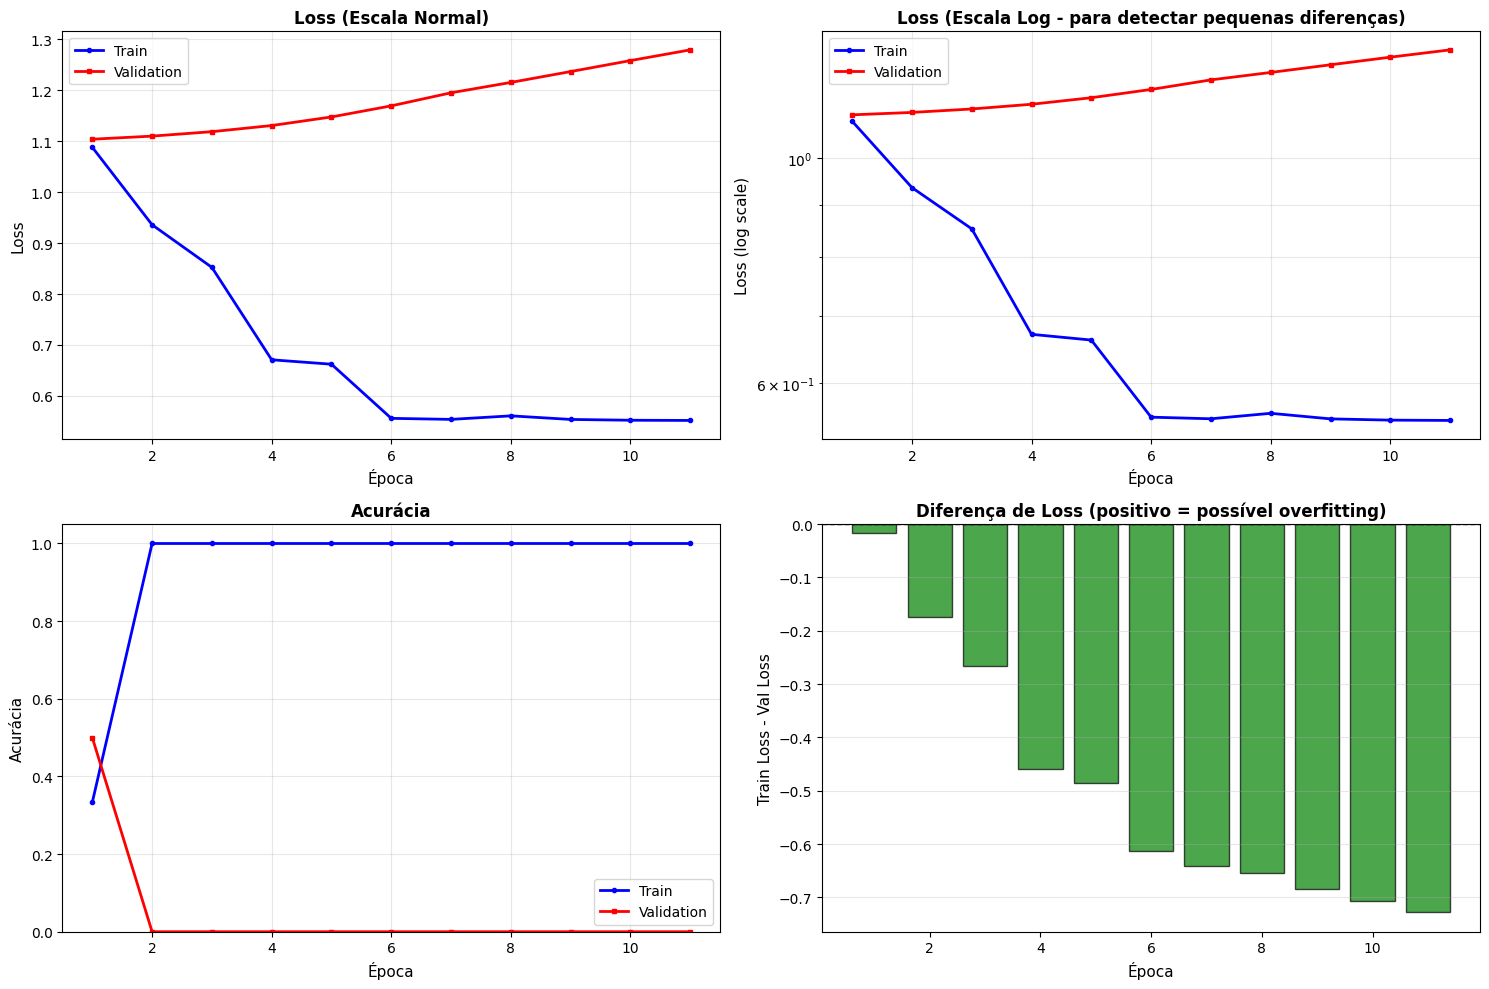


✅ Gráficos de análise de overfitting salvos em '../figures/overfitting_analysis.png'


In [ ]:
if 'history' in locals() and len(history['train_loss']) > 0:
    # ===== VERIFICAÇÃO 5: Visualização Detalhada =====
    print("\n" + "=" * 70)
    print("ANÁLISE DE OVERFITTING - VERIFICAÇÃO 4: VISUALIZAÇÃO DETALHADA")
    print("=" * 70)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot 1: Loss - Escala Normal
    ax = axes[0, 0]
    ax.plot(epochs, history['train_loss'], 'b-', label='Train', linewidth=2, marker='o', markersize=3)
    ax.plot(epochs, history['val_loss'], 'r-', label='Validation', linewidth=2, marker='s', markersize=3)
    ax.set_xlabel('Época', fontsize=11)
    ax.set_ylabel('Loss', fontsize=11)
    ax.set_title('Loss (Escala Normal)', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Loss - Escala Log (melhor para ver pequenas diferenças)
    ax = axes[0, 1]
    ax.semilogy(epochs, history['train_loss'], 'b-', label='Train', linewidth=2, marker='o', markersize=3)
    ax.semilogy(epochs, history['val_loss'], 'r-', label='Validation', linewidth=2, marker='s', markersize=3)
    ax.set_xlabel('Época', fontsize=11)
    ax.set_ylabel('Loss (log scale)', fontsize=11)
    ax.set_title('Loss (Escala Log - para detectar pequenas diferenças)', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, which='both')
    
    # Plot 3: Acurácia
    ax = axes[1, 0]
    ax.plot(epochs, history['train_acc'], 'b-', label='Train', linewidth=2, marker='o', markersize=3)
    ax.plot(epochs, history['val_acc'], 'r-', label='Validation', linewidth=2, marker='s', markersize=3)
    ax.set_xlabel('Época', fontsize=11)
    ax.set_ylabel('Acurácia', fontsize=11)
    ax.set_title('Acurácia', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1.05])
    
    # Plot 4: Diferença entre Train e Validation (indicador de overfitting)
    ax = axes[1, 1]
    loss_diff = [t - v for t, v in zip(history['train_loss'], history['val_loss'])]
    colors = ['red' if d > 0.01 else 'green' for d in loss_diff]
    ax.bar(epochs, loss_diff, color=colors, alpha=0.7, edgecolor='black', linewidth=1)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax.set_xlabel('Época', fontsize=11)
    ax.set_ylabel('Train Loss - Val Loss', fontsize=11)
    ax.set_title('Diferença de Loss (positivo = possível overfitting)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('../figures/overfitting_analysis.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Gráficos de análise de overfitting salvos em '../figures/overfitting_analysis.png'")
else:
    print("Nenhum histórico para visualizar.")